# Churn Exploration & Baseline Model
Notebook to:
1) Load the **fleet_churn.csv** (or `fleet_churn_30.csv`)
2) Preprocess → one-hot encode categoricals
3) Train **XGBoost** baseline
4) Evaluate: ROC AUC, confusion matrix, classification report
5) Plot ROC curve and Feature Importances

> Tip: run this inside your project venv where `xgboost`, `pandas`, and `scikit-learn` are installed.

In [1]:
# !pip install xgboost pandas scikit-learn matplotlib pyarrow
import os
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
CSV_CANDIDATES = [
    DATA_DIR / "fleet_churn.csv",
    DATA_DIR / "fleet_churn_30.csv",
]

# Find dataset
for p in CSV_CANDIDATES:
    if p.exists():
        data_path = p
        break
else:
    raise FileNotFoundError("Put fleet_churn.csv or fleet_churn_30.csv under ./data/")

print("Using dataset:", data_path)
df = pd.read_csv(data_path)
print(df.shape)
df.head()


Using dataset: data/fleet_churn.csv
(6000, 16)


,customer_id,tenure_months,num_vehicles,avg_card_swipes_per_vehicle,monthly_txn_count,monthly_spend,contract_type,region,fuel_program_tier,maintenance_plan,telematics_enabled,industry_naics,late_payment_rate,support_tickets_last_90d,downtime_hours_last_30d,churn
0,C300000,10,24,34.55,952,102211.22,One Year,West,Standard,Full,0,Manufacturing,0.088,1,5.73,0
1,C300001,10,22,37.71,767,60018.83,One Year,Midwest,Basic,NaN,1,Logistics,0.050,2,3.80,0
2,C300002,57,17,31.77,624,37561.11,One Year,West,Basic,Basic,1,Retail,0.278,2,2.94,1
3,C300003,36,11,22.07,262,26856.55,Month-to-Month,Northeast,Premium,Full,0,Retail,0.068,3,6.28,0
4,C300004,42,21,50.53,855,40336.65,Two Year,West,Basic,Full,1,Manufacturing,0.289,5,1.82,0


In [2]:
# Basic cleaning and target
assert "churn" in df.columns, "Expected a 'churn' target column."
y = df["churn"].astype(int).values
X = df.drop(columns=["churn", "customer_id"], errors="ignore").copy()

# One-hot encode categorical columns
cat_cols = X.select_dtypes(include="object").columns.tolist()
X[cat_cols] = X[cat_cols].fillna("NA")
X = pd.get_dummies(X, columns=cat_cols, dummy_na=False)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_val.shape


((4800, 27), (1200, 27))

In [5]:
from xgboost import XGBClassifier
# Count class distribution in y_train
negatives = sum(y_train == 0)
positives = sum(y_train == 1)
# Train a baseline XGBoost model
model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight = negatives / positives,
    reg_lambda=1.0,
    reg_alpha=0.0,
    eval_metric="auc",
    random_state=42,
    tree_method="hist",
)
model.fit(X_train, y_train)

proba_val = model.predict_proba(X_val)[:, 1]
pred_val = (proba_val >= 0.5).astype(int)

auc = roc_auc_score(y_val, proba_val)
print("Validation ROC AUC:", round(float(auc), 4))
print()
print(classification_report(y_val, pred_val, digits=4))
cm = confusion_matrix(y_val, pred_val)
cm


Validation ROC AUC: 0.5283

              precision    recall  f1-score   support

           0     0.6980    0.7299    0.7136       833
           1     0.3161    0.2834    0.2989       367

    accuracy                         0.5933      1200
   macro avg     0.5071    0.5066    0.5062      1200
weighted avg     0.5812    0.5933    0.5868      1200



array([[608, 225],
       [263, 104]])

In [15]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def pick_threshold_by_constraints(y_true, y_score, *,
                                  target_recall=None,
                                  min_precision=None,
                                  mode="tight_above"):  # or "max_recall", "max_F2"
    p, r, t = precision_recall_curve(y_true, y_score)
    p, r, t = p[1:], r[1:], t  # align

    cand = np.arange(len(t))
    if target_recall is not None:
        cand = cand[r[cand] >= target_recall]
    if min_precision is not None:
        cand = cand[p[cand] >= min_precision]

    if len(cand) == 0:
        # fallback: maximize F2 (recall-heavy)
        beta = 2.0
        f2 = (1 + beta**2) * (p * r) / (beta**2 * p + r + 1e-12)
        i = int(np.nanargmax(f2))
        reason = "fallback: max F2"
    else:
        if mode == "tight_above" and target_recall is not None:
            i = cand[np.argmin(r[cand] - target_recall)]
            reason = "tight-above recall target"
        elif mode == "max_recall":
            i = cand[np.argmax(r[cand])]
            reason = "max recall under precision floor"
        else:
            i = cand[0]; reason = "first feasible"

    return {"threshold": float(t[i]),
            "precision": float(p[i]),
            "recall": float(r[i]),
            "index": int(i),
            "reason": reason}

In [17]:
sel = pick_threshold_by_constraints(y_val, proba_val,
                                    target_recall=0.60,
                                    min_precision=0.30,
                                    mode="tight_above")
chosen_threshold = sel["threshold"]
chosen_threshold

0.49491602182388306

In [6]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve

# === 1) Compute class weight for imbalance (neg/pos) on TRAIN ONLY ===
neg = int(np.sum(y_train == 0))
pos = int(np.sum(y_train == 1))
scale_pos_weight = neg / max(pos, 1)
print(f"[info] negatives={neg}, positives={pos}, scale_pos_weight={scale_pos_weight:.2f}")

# === 2) Train with PR-focused metric + early stopping ===
model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=2000,          # large cap; early_stopping will stop earlier
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",        # focus on minority class performance
)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False,
    early_stopping_rounds=100
)

# === 3) Pick a threshold that achieves a target recall on VAL ===
# Set your target recall for class 1 (e.g., 0.70). Increase/decrease to taste.
TARGET_RECALL = 0.70

proba_val = model.predict_proba(X_val)[:, 1]
# Metrics that don't depend on threshold
roc_auc = roc_auc_score(y_val, proba_val)
ap_score = average_precision_score(y_val, proba_val)  # area under PR curve
print(f"[val] ROC AUC={roc_auc:.4f}, PR AUC (AP)={ap_score:.4f}")

prec, rec, thr = precision_recall_curve(y_val, proba_val)
# precision_recall_curve returns len(thr)+1 points; align by ignoring the first prec/rec if needed
# Find lowest threshold that reaches TARGET_RECALL
idx = np.where(rec >= TARGET_RECALL)[0]
if len(idx) == 0:
    # Can't hit the target; take the max achievable recall
    best_idx = np.argmax(rec)
    chosen_threshold = 0.5 if best_idx == 0 else thr[best_idx - 1]
    achieved_recall = rec[best_idx]
    achieved_precision = prec[best_idx]
    print(f"[warn] Could not reach recall {TARGET_RECALL:.2f}. "
          f"Using threshold {chosen_threshold:.4f} achieving recall={achieved_recall:.3f}, precision={achieved_precision:.3f}")
else:
    best_idx = idx[0]
    chosen_threshold = 0.5 if best_idx == 0 else thr[best_idx - 1]
    achieved_recall = rec[best_idx]
    achieved_precision = prec[best_idx]
    print(f"[val] Threshold selected={chosen_threshold:.4f} "
          f"to reach recall≈{achieved_recall:.3f}, precision≈{achieved_precision:.3f}")

# === 4) Evaluate using the chosen threshold ===
y_val_pred = (proba_val >= chosen_threshold).astype(int)
print("\n[Validation classification report @ chosen threshold]")
print(classification_report(y_val, y_val_pred, digits=4))

[info] negatives=3333, positives=1467, scale_pos_weight=2.27


/home/airflow/.local/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[val] ROC AUC=0.5450, PR AUC (AP)=0.3518
[val] Threshold selected=0.5000 to reach recall≈1.000, precision≈0.306

[Validation classification report @ chosen threshold]
              precision    recall  f1-score   support

           0     0.7220    0.6267    0.6710       833
           1     0.3480    0.4523    0.3934       367

    accuracy                         0.5733      1200
   macro avg     0.5350    0.5395    0.5322      1200
weighted avg     0.6076    0.5733    0.5861      1200



In [7]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, fbeta_score
)

# === 1) Compute class weight on TRAIN ONLY ===
neg = int(np.sum(y_train == 0))
pos = int(np.sum(y_train == 1))
scale_pos_weight = neg / max(pos, 1)
print(f"[info] negatives={neg}, positives={pos}, scale_pos_weight={scale_pos_weight:.2f}")

# === 2) Train (PR-focused) with early stopping in constructor ===
model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=2000,          # large cap; early stopping will cut it
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    early_stopping_rounds=100   # <-- set here to avoid deprecation warning
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# === 3) Scores on VAL (threshold-free metrics) ===
proba_val = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, proba_val)
ap_score = average_precision_score(y_val, proba_val)
print(f"[val] ROC AUC={roc_auc:.4f}, PR AUC (AP)={ap_score:.4f}")

# === 4) Threshold selection with constraints ===
TARGET_RECALL = 0.60
MIN_PRECISION = 0.30

prec, rec, thr = precision_recall_curve(y_val, proba_val)
# precision_recall_curve returns arrays where len(thr) = len(prec) - 1 = len(rec) - 1
prec = prec[:-1]
rec = rec[:-1]
thr  = thr

# Indices that satisfy both constraints
ok = np.where((rec >= TARGET_RECALL) & (prec >= MIN_PRECISION))[0]

if len(ok) > 0:
    # Pick the lowest threshold that meets constraints (maximizes recall)
    best_i = ok[0]  # first such index corresponds to lowest threshold
    chosen_threshold = thr[best_i]
    chosen_reason = f"meets recall≥{TARGET_RECALL:.2f} & precision≥{MIN_PRECISION:.2f}"
else:
    # Fallback: maximize F2 (recall-heavy) over all thresholds
    f2 = (1 + 2**2) * (prec * rec) / (2**2 * prec + rec + 1e-12)
    best_i = int(np.nanargmax(f2))
    chosen_threshold = thr[best_i]
    chosen_reason = "fallback to max F2 (constraints not achievable)"

achieved_recall = rec[best_i]
achieved_precision = prec[best_i]
print(f"[val] Selected threshold={chosen_threshold:.4f} "
      f"(recall={achieved_recall:.3f}, precision={achieved_precision:.3f}) — {chosen_reason}")

# === 5) Final classification report at chosen threshold ===
y_val_pred = (proba_val >= chosen_threshold).astype(int)
print("\n[Validation classification report @ chosen threshold]")
print(classification_report(y_val, y_val_pred, digits=4))

[info] negatives=3333, positives=1467, scale_pos_weight=2.27
[val] ROC AUC=0.5450, PR AUC (AP)=0.3518
[val] Selected threshold=0.4376 (recall=1.000, precision=0.306) — meets recall≥0.60 & precision≥0.30

[Validation classification report @ chosen threshold]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       833
           1     0.3058    1.0000    0.4684       367

    accuracy                         0.3058      1200
   macro avg     0.1529    0.5000    0.2342      1200
weighted avg     0.0935    0.3058    0.1433      1200



/home/airflow/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/airflow/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/airflow/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, average_precision_score

def pick_threshold_safe(y_true, y_score, *,
                        target_recall=0.60,
                        min_precision=0.30,
                        mode="tight_above",          # "tight_above" | "max_recall" | "max_F2"
                        min_pos_rate=0.05,           # avoid all-0s (pos_rate≈0) or all-1s (pos_rate≈1)
                        max_pos_rate=0.95,
                        min_support=20               # at least this many predicted samples in EACH class
                        ):
    """
    Select a decision threshold under precision/recall constraints,
    while preventing single-class collapse via pos_rate & min_support guards.
    """
    # PR curve
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    prec_t, rec_t, thr_t = prec[1:], rec[1:], thr   # align arrays

    n = len(y_true)

    # --- Compute predicted positive rate and supports at each threshold ---
    # pos_rate(t) = mean(y_score >= t)
    pos_rate = np.array([(y_score >= t).mean() for t in thr_t])
    pos_support = (pos_rate * n).astype(int)
    neg_support = n - pos_support

    # --- Feasibility mask: meet P/R constraints AND guardrails ---
    feasible = (
        (rec_t >= target_recall) &
        (prec_t >= min_precision) &
        (pos_rate >= min_pos_rate) & (pos_rate <= max_pos_rate) &
        (pos_support >= min_support) & (neg_support >= min_support)
    )
    idx = np.where(feasible)[0]

    # --- Choose among feasible points ---
    if len(idx) > 0:
        if mode == "tight_above":
            # closest recall above target
            chosen = idx[np.argmin(rec_t[idx] - target_recall)]
            reason = "tight-above target with guardrails"
        elif mode == "max_recall":
            chosen = idx[np.argmax(rec_t[idx])]
            reason = "max recall under guardrails"
        else:
            # Maximize F2 among feasible
            beta = 2.0
            f2_all = (1 + beta**2) * (prec_t[idx] * rec_t[idx]) / (beta**2 * prec_t[idx] + rec_t[idx] + 1e-12)
            chosen = idx[int(np.nanargmax(f2_all))]
            reason = "max F2 among feasible"
    else:
        # Fallback: relax to precision floor only, still keep guardrails
        feasible2 = (
            (prec_t >= min_precision) &
            (pos_rate >= min_pos_rate) & (pos_rate <= max_pos_rate) &
            (pos_support >= min_support) & (neg_support >= min_support)
        )
        idx2 = np.where(feasible2)[0]
        if len(idx2) > 0:
            beta = 2.0
            f2_all = (1 + beta**2) * (prec_t[idx2] * rec_t[idx2]) / (beta**2 * prec_t[idx2] + rec_t[idx2] + 1e-12)
            chosen = idx2[int(np.nanargmax(f2_all))]
            reason = "fallback: max F2 with guardrails (recall target unmet)"
        else:
            # Final fallback: pure max F2 anywhere (still avoids NaNs)
            beta = 2.0
            f2 = (1 + beta**2) * (prec_t * rec_t) / (beta**2 * prec_t + rec_t + 1e-12)
            chosen = int(np.nanargmax(f2))
            reason = "final fallback: max F2 (guardrails infeasible)"

    return {
        "threshold": float(thr_t[chosen]),
        "precision": float(prec_t[chosen]),
        "recall": float(rec_t[chosen]),
        "pos_rate": float(pos_rate[chosen]),
        "pos_support": int(pos_support[chosen]),
        "neg_support": int(neg_support[chosen]),
        "index": int(chosen),
        "reason": reason
    }

# ===== Usage after training =====
proba_val = model.predict_proba(X_val)[:, 1]
print(f"[val] ROC AUC={roc_auc_score(y_val, proba_val):.4f}, PR AUC={average_precision_score(y_val, proba_val):.4f}")

sel = pick_threshold_safe(
    y_val, proba_val,
    target_recall=0.60,
    min_precision=0.30,
    mode="tight_above",
    min_pos_rate=0.05,  # tweak if you expect very rare positives
    max_pos_rate=0.95,
    min_support=20
)

print(f"[selector] threshold={sel['threshold']:.4f} "
      f"recall={sel['recall']:.3f} precision={sel['precision']:.3f} "
      f"pos_rate={sel['pos_rate']:.3f} "
      f"(pos={sel['pos_support']}, neg={sel['neg_support']}) — {sel['reason']}")

yhat = (proba_val >= sel["threshold"]).astype(int)
print("\n[Validation @ chosen threshold]")
print(classification_report(y_val, yhat, digits=4, zero_division=0))

[val] ROC AUC=0.5450, PR AUC=0.3518
[selector] threshold=0.4949 recall=0.602 precision=0.323 pos_rate=0.572 (pos=686, neg=514) — tight-above target with guardrails

[Validation @ chosen threshold]
              precision    recall  f1-score   support

           0     0.7179    0.4430    0.5479       833
           1     0.3236    0.6049    0.4217       367

    accuracy                         0.4925      1200
   macro avg     0.5208    0.5239    0.4848      1200
weighted avg     0.5973    0.4925    0.5093      1200



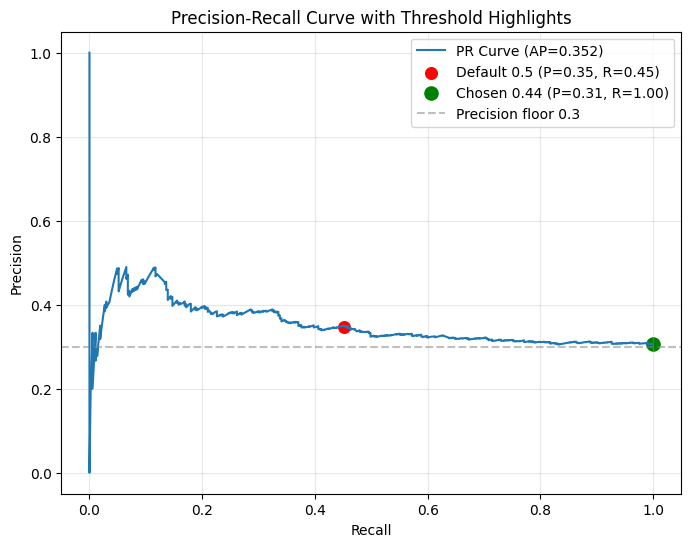

Chosen threshold=0.4376, recall=1.000, precision=0.306 — Valid threshold found


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- Compute PR curve ---
prec, rec, thr = precision_recall_curve(y_val, proba_val)

# Properly align threshold-based indices
prec_t = prec[1:]
rec_t  = rec[1:]
thr_t  = thr

# --- Highlight Default Threshold (0.5) ---
default_idx = (np.abs(thr_t - 0.5)).argmin()
default_rec = rec_t[default_idx]
default_prec = prec_t[default_idx]

# --- Find Best Threshold under Constraints ---
TARGET_RECALL = 0.60
MIN_PRECISION = 0.30

ok = np.where((rec_t >= TARGET_RECALL) & (prec_t >= MIN_PRECISION))[0]
if len(ok) > 0:
    best_i = ok[np.argmax(rec_t[ok])]  # highest recall among valid ones
    chosen_threshold = thr_t[best_i]
    chosen_rec = rec_t[best_i]
    chosen_prec = prec_t[best_i]
    reason = "Valid threshold found"
else:
    # Fallback to max F2
    f2 = (1 + 2**2) * (prec_t * rec_t) / (4 * prec_t + rec_t + 1e-12)
    best_i = int(np.nanargmax(f2))
    chosen_threshold = thr_t[best_i]
    chosen_rec = rec_t[best_i]
    chosen_prec = prec_t[best_i]
    reason = "Fallback to F2"

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, label=f"PR Curve (AP={average_precision_score(y_val, proba_val):.3f})")
plt.scatter(default_rec, default_prec, color='red', s=70, label=f"Default 0.5 (P={default_prec:.2f}, R={default_rec:.2f})")
plt.scatter(chosen_rec, chosen_prec, color='green', s=90, label=f"Chosen {chosen_threshold:.2f} (P={chosen_prec:.2f}, R={chosen_rec:.2f})")
plt.axhline(MIN_PRECISION, color='gray', linestyle='--', alpha=0.5, label=f"Precision floor {MIN_PRECISION}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Threshold Highlights")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Chosen threshold={chosen_threshold:.4f}, recall={chosen_rec:.3f}, precision={chosen_prec:.3f} — {reason}")

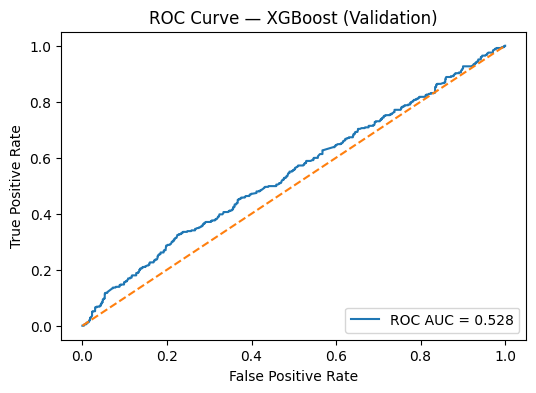

In [11]:
# Plot ROC curve (matplotlib only; no style/colors specified)
fpr, tpr, thr = roc_curve(y_val, proba_val)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — XGBoost (Validation)')
plt.legend(loc='lower right')
plt.show()


In [12]:
# Feature importances (gain-based)
importances = model.feature_importances_
feat_imp = (
    pd.DataFrame({"feature": X_train.columns, "importance": importances})
      .sort_values("importance", ascending=False)
      .head(25)
      .reset_index(drop=True)
)
feat_imp


,feature,importance
0,fuel_program_tier_Basic,0.051394
1,late_payment_rate,0.047226
2,support_tickets_last_90d,0.045969
3,monthly_spend,0.042435
4,monthly_txn_count,0.040986
5,downtime_hours_last_30d,0.040843
6,avg_card_swipes_per_vehicle,0.039622
7,num_vehicles,0.038084
8,fuel_program_tier_Standard,0.037649
9,tenure_months,0.037517


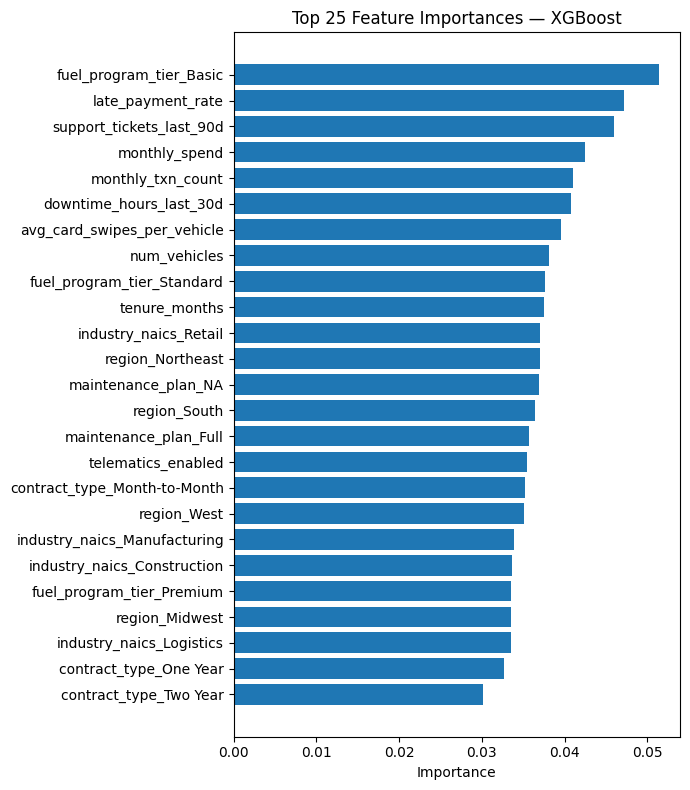

In [13]:
# Plot top feature importances (matplotlib only)
plt.figure(figsize=(7, 8))
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 25 Feature Importances — XGBoost")
plt.tight_layout()
plt.show()


## Save the trained model (optional)

In [ ]:
# Save the trained model to disk for reuse (optional)
from joblib import dump
models_dir = Path("models"); models_dir.mkdir(parents=True, exist_ok=True)
dump(model, models_dir / "notebook_xgb_model.pkl")
print("Saved:", models_dir / "notebook_xgb_model.pkl")


In [2]:
import json, glob, os, pandas as pd

# read our saved metrics from training logs (fallback: parse Airflow log or recompute quickly)
# here we compute quickly from val.parquet to be definitive:
val = pd.read_parquet("data/processed/val.parquet")
y = val["label"].values
X = val.drop(columns=["label"])
import joblib
from sklearn.metrics import roc_auc_score, f1_score
proba = joblib.load("models/latest_model.pkl").predict_proba(X)[:,1]
print("val_auc:", roc_auc_score(y, proba))
print("val_f1 @0.5:", f1_score(y, (proba>=0.5).astype(int)))

val_auc: 0.5325090909090909
val_f1 @0.5: 0.1814516129032258


In [5]:
# how many features?
#python - <<'PY'
import pandas as pd; df=pd.read_parquet("data/processed/train.parquet")
print("rows:", len(df), "cols:", df.shape[1])
print("label mean (train):", df["label"].mean())
print("first 5 cols:", list(df.columns[:5]))
#PY

rows: 4800 cols: 28
label mean (train): 0.30395833333333333
first 5 cols: ['tenure_months', 'num_vehicles', 'avg_card_swipes_per_vehicle', 'monthly_txn_count', 'monthly_spend']
